In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from scipy.interpolate import make_interp_spline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, ZeroPadding2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFont
from tensorflow.keras import layers
from collections import defaultdict

## 1. Data overview

In [2]:
data = np.load('../datasets/pneumoniamnist.npz')

In [3]:
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [4]:
x_train = data['train_images']
x_test = data['test_images']
x_val = data['val_images']

y_train = data['train_labels']
y_test = data['test_labels']
y_val = data['val_labels']

In [5]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (4708, 28, 28)
Shape of y_train: (4708, 1)
Shape of x_test: (624, 28, 28)
Shape of y_test: (624, 1)
Shape of x_val: (524, 28, 28)
Shape of y_val: (524, 1)


 The shapes indicate that the images have dimensions of 28x28 pixels, and there are a total of 4708 training samples, 624 test samples, and 524 validation samples.

In [6]:
img_size = 28
class_names = ["Normal", "Pneumonia"]

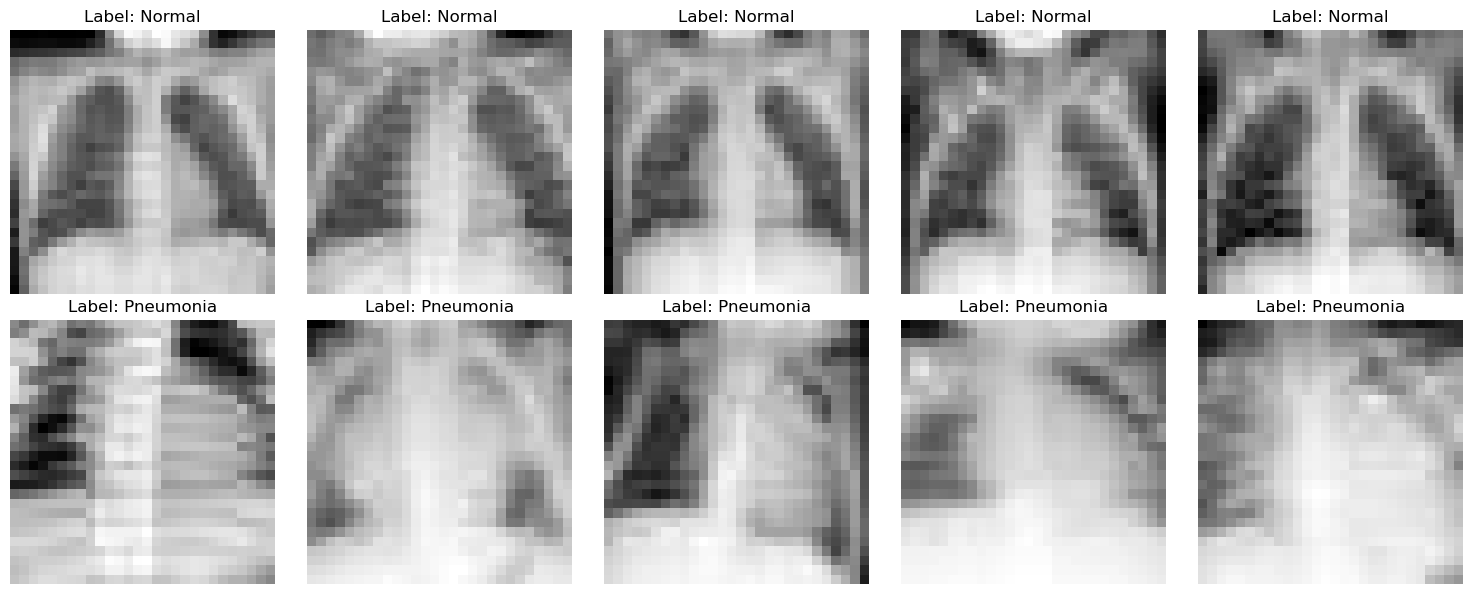

In [7]:
num_images_per_class = 5

# Find indices of "Normal" (label 0) and "Pneumonia" (label 1) images
normal_indices = [i for i, label in enumerate(y_train.flatten()) if label == 0]
pneumonia_indices = [i for i, label in enumerate(y_train.flatten()) if label == 1]

# Randomly select a few indices for each class
random_normal_indices = random.sample(normal_indices, num_images_per_class)
random_pneumonia_indices = random.sample(pneumonia_indices, num_images_per_class)

# Plot the images in a grid
fig, axes = plt.subplots(2, num_images_per_class, figsize=(15, 6))

# Display "Normal" images
for i, index in enumerate(random_normal_indices):
    axes[0, i].imshow(x_train[index], cmap='gray')
    axes[0, i].set_title(f"Label: Normal")
    axes[0, i].axis('off')

# Display "Pneumonia" images
for i, index in enumerate(random_pneumonia_indices):
    axes[1, i].imshow(x_train[index], cmap='gray')
    axes[1, i].set_title(f"Label: Pneumonia")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'pneumonia')

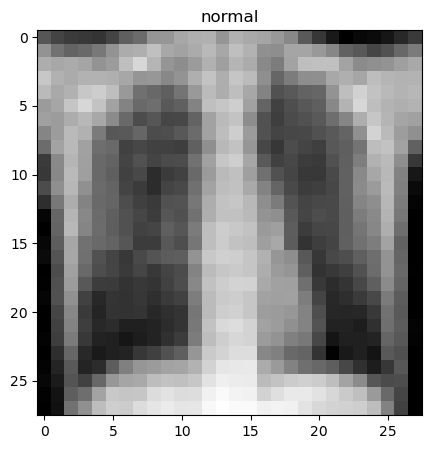

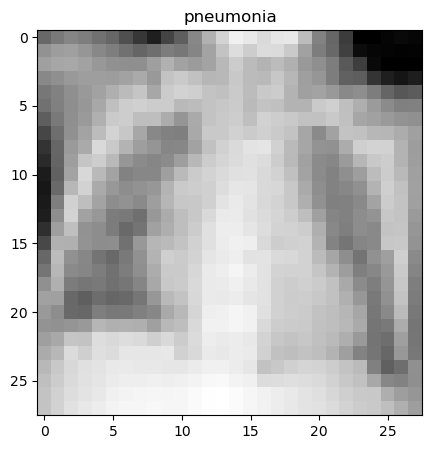

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[normal_indices[0]], cmap='gray')
plt.title('normal')

plt.figure(figsize = (5,5))
plt.imshow(x_train[pneumonia_indices[0]], cmap='gray')
plt.title('pneumonia')

In [9]:
def visualize_tsne(image_data, labels, class_names):
    image_data_flatten = image_data.reshape(image_data.shape[0], -1)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(image_data_flatten)

    tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
    
    # Convert NumPy array to Pandas Series, flatten, and map numeric labels to class names
    tsne_df['Label'] = pd.Series(labels.flatten()).map({0: class_names[0], 1: class_names[1]})
    
    # Define custom colors for each class
    color_dict = {class_names[0]: '#9f1f31', class_names[1]: '#03608C'}

    # Create a scatter plot using seaborn with custom colors
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette=color_dict, alpha=0.7)

    plt.title("t-SNE Visualization of Image Clustering")
    plt.show()


d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\S

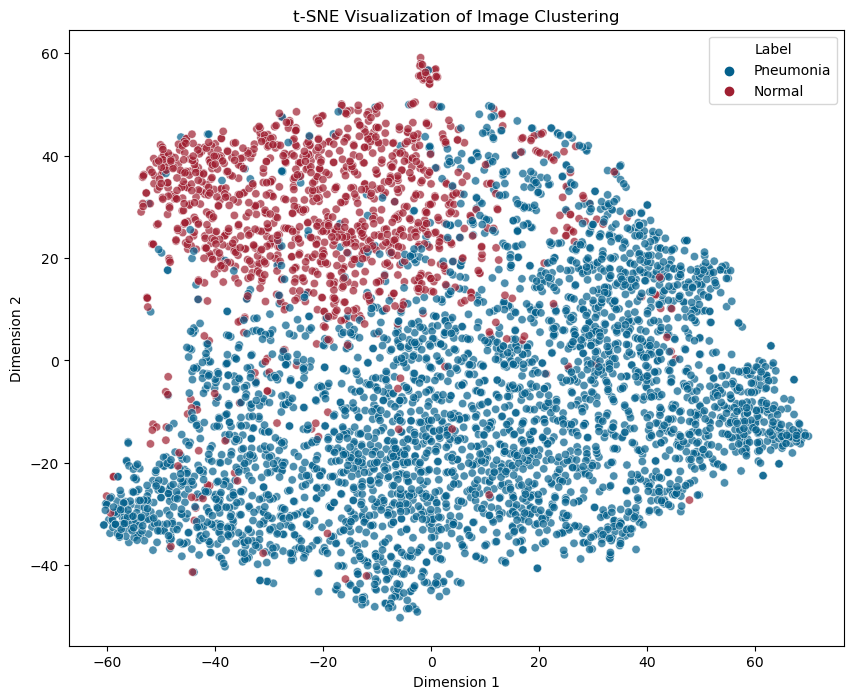

In [10]:
visualize_tsne(x_train, y_train, class_names)

## Data Preprocessing

Data normalization: reduce the effect of lightning, convert the data range from 0-255 to 0-1

In [11]:
#Normalization
x_train1 = ((np.array(x_train) / 255) - 0.5) * 2
x_val1 = ((np.array(x_val) / 255) - 0.5) * 2
x_test1 = ((np.array(x_test) / 255) - 0.5) * 2

In [12]:
# data flatten
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [13]:
# data normalization for CNN in (4708, 28, 28, 1) shape
x_train2 = x_train1.reshape(-1, img_size, img_size, 1)
x_val2 = x_val1.reshape(-1, img_size, img_size, 1)
x_test2 = x_test1.reshape(-1, img_size, img_size, 1)

In [14]:
print(x_train1.shape)
print(x_train_flat.shape)
print(x_train2.shape)

(4708, 28, 28)
(4708, 784)
(4708, 28, 28, 1)


In [15]:
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,       
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

datagen.fit(x_train2)

Apply Gaussiam blur to the images: This helps to emphasize the features in the image.

In [16]:
# Apply Gaussian blur to the dataset.
import cv2
'''
alpha: Weight of the original image. Increasing alpha increases the contribution of the original image, making the result closer to the original.
beta: Weight of the blurred version. Increasing beta increases the contribution of the blurred version, making the result closer to the blurred image.
'''
# Function to apply Gaussian Blur to a single image
def apply_gaussian_blur_weighted(image, alpha=2, beta=-0.2):
    blurred_image = cv2.addWeighted(image, alpha, cv2.GaussianBlur(image, (0, 0), 2), beta, 0)
    return blurred_image

# Apply Gaussian Blur to the entire dataset
x_train_blurred = np.array([apply_gaussian_blur_weighted(img) for img in x_train])
x_val_blurred = np.array([apply_gaussian_blur_weighted(img) for img in x_val])
x_test_blurred = np.array([apply_gaussian_blur_weighted(img) for img in x_test])

#use for svm model
x_train_blurred_flat = x_train_blurred.reshape(-1, img_size*img_size)
x_val_blurred_flat = x_val_blurred.reshape(-1, img_size*img_size)
x_test_blurred_flat = x_test_blurred.reshape(-1, img_size*img_size)

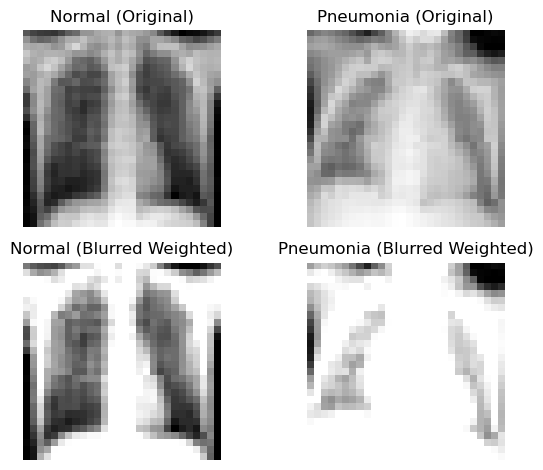

In [17]:
# Display a sample of original and blurred images for comparison
# Original images
plt.subplot(2, 2, 1)
plt.imshow(x_train[normal_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Normal (Original)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(x_train[pneumonia_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Pneumonia (Original)')
plt.axis('off')

# Weighted blurred images
plt.subplot(2, 2, 3)
plt.imshow(x_train_blurred[normal_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Normal (Blurred Weighted)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(x_train_blurred[pneumonia_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Pneumonia (Blurred Weighted)')
plt.axis('off')

plt.tight_layout()
plt.show()



## Model Training -LR/ KNN/ SVM/ CNN

#### Train Logistic Regression Function

In [18]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_classification(x_train, y_train, x_test, y_test):
    
    # Initialize Logistic Regression classifier with L2 regularization and the 'lbfgs' solver
    logistic_reg_classifier = LogisticRegression(solver='lbfgs', penalty='l2')
    
    # Fit LR classifier
    logistic_reg_classifier.fit(x_train, y_train)
    predictions = logistic_reg_classifier.predict(x_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)
    confusion_mat = confusion_matrix(y_test, predictions)

    # Display results
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('\nClassification Report:\n', classification_rep)
    print('\nConfusion Matrix:\n', confusion_mat)

    return accuracy, classification_rep, confusion_mat


In [19]:
accuracy, classification_rep, confusion_mat_log = logistic_regression_classification(x_train_flat, y_train, x_test_flat, y_test)

d:\Software\conda\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 83.17%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.59      0.72       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624


Confusion Matrix:
 [[137  97]
 [  8 382]]


d:\Software\conda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


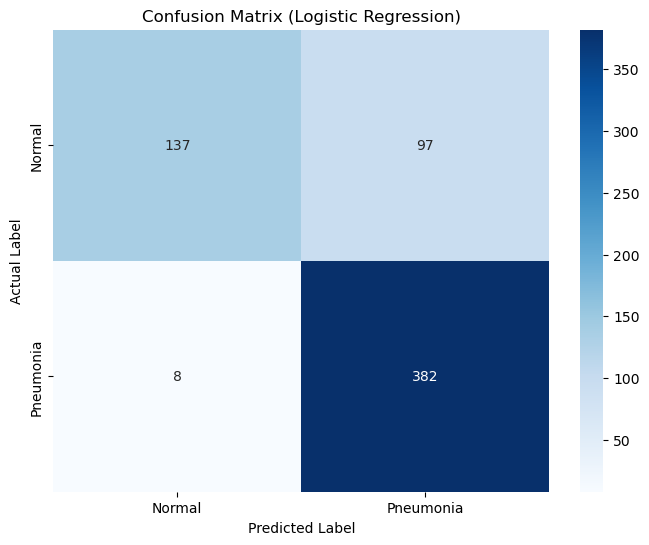

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_log, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

##### Train KNN Model

In [21]:
def knn_classification(x_train, y_train, x_test, y_test, n_neighbors):
    
    # Fit KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(x_train, y_train.ravel())
    predictions = knn_classifier.predict(x_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test.ravel(), predictions)
    classification_rep = classification_report(y_test.ravel(), predictions)
    confusion_mat = confusion_matrix(y_test.ravel(), predictions)

    # Display results
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('\nClassification Report:\n', classification_rep)
    print('\nConfusion Matrix:\n', confusion_mat)

    return accuracy, classification_rep, confusion_mat
    

In [22]:
def knn_error_rates(x_train, y_train, x_val, y_val, k_values):
    train_errors = []
    val_errors = []

    for k in k_values:
        # Train KNN model
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(x_train, y_train.ravel())

        # Calculate error rates
        train_preds = knn_classifier.predict(x_train)
        val_preds = knn_classifier.predict(x_val)

        train_error = 1 - accuracy_score(y_train.ravel(), train_preds)
        val_error = 1 - accuracy_score(y_val.ravel(), val_preds)

        # Append errors to lists
        train_errors.append(train_error)
        val_errors.append(val_error)

    return train_errors, val_errors

In [23]:
def plot_knn_error_rates(x_train, y_train, x_val, y_val, k_values):

    train_errors, val_errors = knn_error_rates(x_train, y_train, x_val, y_val, k_values)

    plt.figure(figsize=(10, 6))
    
    smooth_k_values = np.linspace(min(k_values), max(k_values), 100)

    # Interpolate errors for the smooth curve
    smooth_train_errors = np.interp(smooth_k_values, k_values, train_errors)
    smooth_val_errors = np.interp(smooth_k_values, k_values, val_errors)

    plt.plot(smooth_k_values, smooth_train_errors, label='Training Error',  color='#03608C')
    plt.plot(smooth_k_values, smooth_val_errors, label='Validation Error', color='#9f1f31')

    plt.title('Training and Validation Error Rates for Different K Values')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(False)
    plt.show()

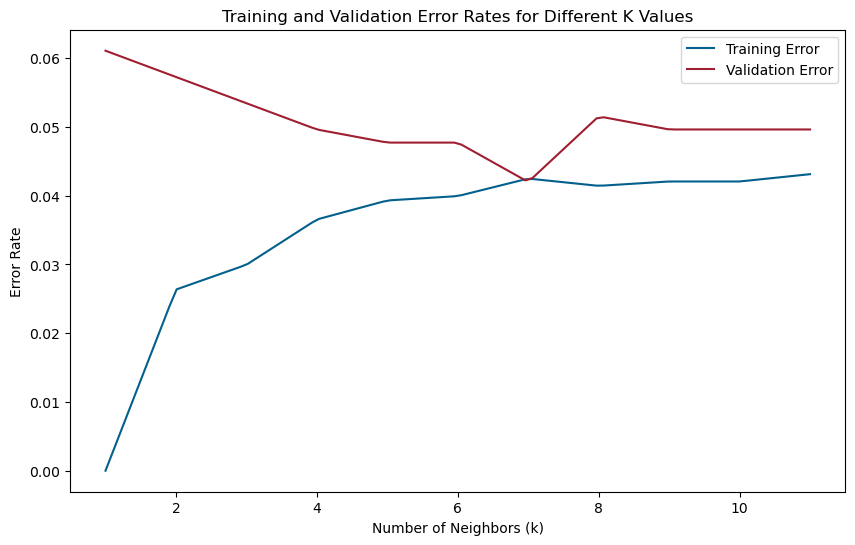

In [24]:
k_values = [k for k in range(1, 12)]
plot_knn_error_rates(x_train_flat, y_train, x_val_flat, y_val, k_values)

In [25]:
accuracy, classification_rep, confusion_mat_knn = knn_classification(x_train_flat, y_train, x_test_flat, y_test, 8)

Accuracy: 83.97%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.62      0.74       234
           1       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624


Confusion Matrix:
 [[144  90]
 [ 10 380]]


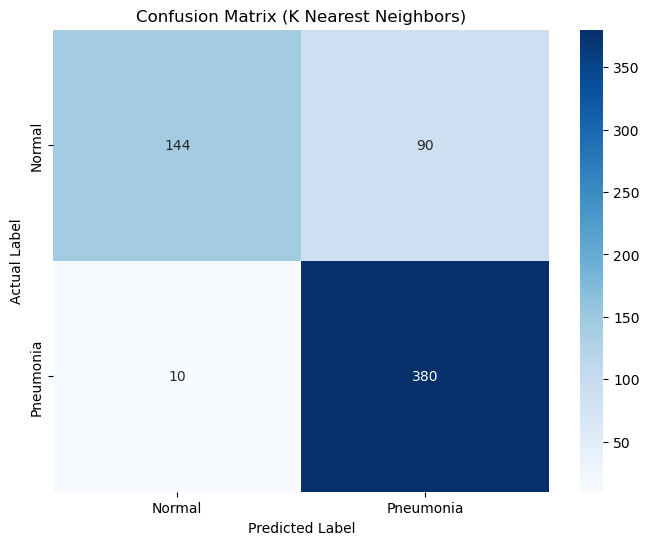

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_knn, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (K Nearest Neighbors)")
plt.show()

#### Train SVM Model

In [27]:
def svm_classifier(x_train, y_train):
    # Fitting the SVM classifiers
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': ['auto']
    }

    # Creating the SVM classifier with GridSearchCV
    clf = GridSearchCV(SVC(kernel='poly'), param_grid, verbose=3, cv=5)
    clf.fit(x_train, y_train)

    # the best parameters found by grid search
    print("Best parameters found by grid search:")
    print(clf.best_params_)
    
    print("\nBest estimator found by grid search:")
    print(clf.best_estimator_)

    return clf


In [28]:
def test_images(clf, x_test, y_test):
    predictions = clf.predict(x_test)
    
    # Evaluate the performance
    accuracy = accuracy_score(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)
    confusion_mat = confusion_matrix(y_test, predictions)

    # Display results
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('\nClassification Report:\n', classification_rep)
    print('\nConfusion Matrix:\n', confusion_mat)

    return accuracy, classification_rep, confusion_mat

In [29]:
clf = svm_classifier(x_train_flat, y_train.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...............C=0.001, gamma=auto;, score=0.956 total time=   0.8s
[CV 2/5] END ...............C=0.001, gamma=auto;, score=0.966 total time=   0.9s
[CV 3/5] END ...............C=0.001, gamma=auto;, score=0.955 total time=   0.9s
[CV 4/5] END ...............C=0.001, gamma=auto;, score=0.959 total time=   0.9s
[CV 5/5] END ...............C=0.001, gamma=auto;, score=0.960 total time=   0.9s
[CV 1/5] END ................C=0.01, gamma=auto;, score=0.956 total time=   0.8s
[CV 2/5] END ................C=0.01, gamma=auto;, score=0.966 total time=   0.9s
[CV 3/5] END ................C=0.01, gamma=auto;, score=0.955 total time=   0.9s
[CV 4/5] END ................C=0.01, gamma=auto;, score=0.959 total time=   0.9s
[CV 5/5] END ................C=0.01, gamma=auto;, score=0.960 total time=   0.9s
[CV 1/5] END .................C=0.1, gamma=auto;, score=0.956 total time=   0.8s
[CV 2/5] END .................C=0.1, gamma=auto;,

In [30]:
accuracy, classification_rep, confusion_mat_svm = test_images(clf, x_test_flat, y_test.ravel())

Accuracy: 83.49%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.58      0.72       234
           1       0.80      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624


Confusion Matrix:
 [[135  99]
 [  4 386]]


Show the heatmap based on the confusion matrix

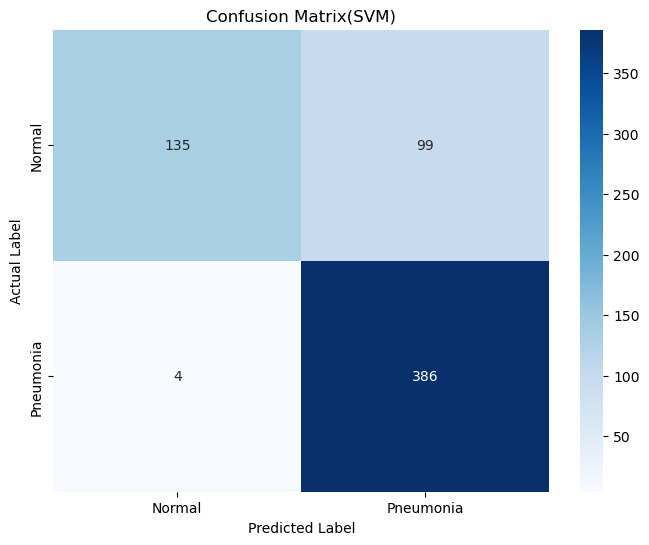

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_svm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix(SVM)")
plt.show()

Train SVM on the Gaussian Blurred dataset

In [32]:
clf2 = svm_classifier(x_train_blurred_flat, y_train.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...............C=0.001, gamma=auto;, score=0.930 total time=   1.1s
[CV 2/5] END ...............C=0.001, gamma=auto;, score=0.937 total time=   1.1s
[CV 3/5] END ...............C=0.001, gamma=auto;, score=0.938 total time=   1.1s
[CV 4/5] END ...............C=0.001, gamma=auto;, score=0.936 total time=   1.1s
[CV 5/5] END ...............C=0.001, gamma=auto;, score=0.933 total time=   1.1s
[CV 1/5] END ................C=0.01, gamma=auto;, score=0.930 total time=   1.1s
[CV 2/5] END ................C=0.01, gamma=auto;, score=0.937 total time=   1.1s
[CV 3/5] END ................C=0.01, gamma=auto;, score=0.938 total time=   1.1s
[CV 4/5] END ................C=0.01, gamma=auto;, score=0.936 total time=   1.1s
[CV 5/5] END ................C=0.01, gamma=auto;, score=0.933 total time=   1.1s
[CV 1/5] END .................C=0.1, gamma=auto;, score=0.930 total time=   1.1s
[CV 2/5] END .................C=0.1, gamma=auto;,

In [33]:
accuracy, classification_rep, confusion_mat_svm_blurred = test_images(clf, x_test_blurred_flat, y_test.ravel())

Accuracy: 72.92%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.30      0.46       234
           1       0.70      0.98      0.82       390

    accuracy                           0.73       624
   macro avg       0.81      0.64      0.64       624
weighted avg       0.78      0.73      0.68       624


Confusion Matrix:
 [[ 71 163]
 [  6 384]]


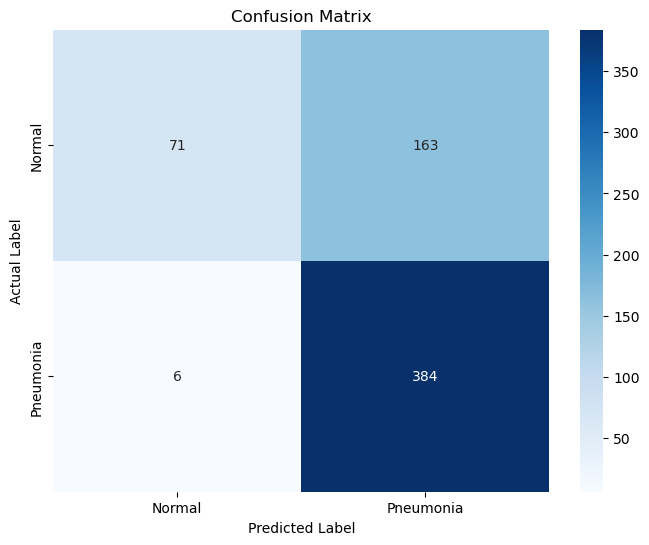

In [34]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_svm_blurred, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

## CNN

`Model Training:`  
Key components of the architecture:  
    - Convolutional layers with ReLU activation.  
    - Batch normalization after each convolutional layer.  
    - MaxPooling layers for downsampling.  
    - Dropout layers for regularization.  
    - Dense layers with ReLU activation for final classification.  
    - Sigmoid activation in the output layer for binary classification.  
    - Binary crossentropy loss for binary classification.  

In [62]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))


model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))

# Flatten and Fully Connected layers
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])


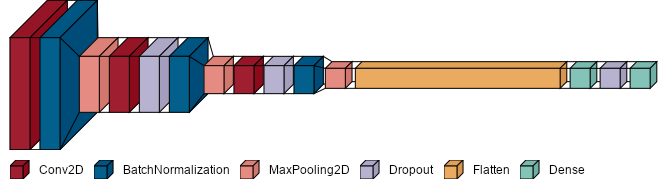

In [63]:
import visualkeras
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font) # selected font
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#9f1f31'
color_map[layers.MaxPooling2D]['fill'] = '#E68B81'
color_map[layers.Dropout]['fill'] = '#B7B2D0'
color_map[layers.Dense]['fill'] = '#84C3B7'
color_map[layers.Flatten]['fill'] = '#EAAA60'
color_map[layers.BatchNormalization]['fill'] = '#03608C'
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map)

Use learning rate reduction to avoid small learning rate(overfitting) and large learning rate(underfitting)

In [64]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

In [65]:
history = model.fit(x_train2, y_train, epochs = 12 , validation_data = (x_val2, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
148/148 [==============================] - 4s 17ms/step - loss: 0.2462 - accuracy: 0.9180 - val_loss: 2.5241 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/12
148/148 [==============================] - 2s 15ms/step - loss: 0.1408 - accuracy: 0.9545 - val_loss: 4.6972 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 3/12
148/148 [==============================] - 2s 15ms/step - loss: 0.1217 - accuracy: 0.9596 - val_loss: 1.0672 - val_accuracy: 0.8511 - lr: 0.0010
Epoch 4/12
148/148 [==============================] - 2s 15ms/step - loss: 0.0947 - accuracy: 0.9658 - val_loss: 0.1794 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 5/12
148/148 [==============================] - 2s 15ms/step - loss: 0.0835 - accuracy: 0.9722 - val_loss: 0.0822 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 6/12
148/148 [==============================] - 2s 15ms/step - loss: 0.0817 - accuracy: 0.9698 - val_loss: 0.1641 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 7/12
148/148 [==============================] - 2s 17ms/st

In [66]:
print("Test loss - " , model.evaluate(x_test2,y_test)[0])
print("Test Accuracy - " , model.evaluate(x_test2,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 4ms/step - loss: 1.6774 - accuracy: 0.8782
Test loss -  1.6774022579193115
20/20 [==============================] - 0s 8ms/step - loss: 1.6774 - accuracy: 0.8782
Test Accuracy -  87.82051205635071 %


With augmentation data

In [67]:
history = model.fit(datagen.flow(x_train2, y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val2, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
148/148 [==============================] - 3s 19ms/step - loss: 0.6362 - accuracy: 0.8891 - val_loss: 0.2746 - val_accuracy: 0.8969 - lr: 9.0000e-05
Epoch 2/12
148/148 [==============================] - 3s 18ms/step - loss: 0.2827 - accuracy: 0.9087 - val_loss: 0.2416 - val_accuracy: 0.9160 - lr: 9.0000e-05
Epoch 3/12
148/148 [==============================] - 3s 18ms/step - loss: 0.2348 - accuracy: 0.9155 - val_loss: 0.2009 - val_accuracy: 0.9218 - lr: 9.0000e-05
Epoch 4/12
148/148 [==============================] - 3s 18ms/step - loss: 0.1855 - accuracy: 0.9267 - val_loss: 0.2204 - val_accuracy: 0.9179 - lr: 9.0000e-05
Epoch 5/12
148/148 [==============================] - 3s 18ms/step - loss: 0.2049 - accuracy: 0.9269 - val_loss: 0.1702 - val_accuracy: 0.9351 - lr: 9.0000e-05
Epoch 6/12
148/148 [==============================] - 3s 19ms/step - loss: 0.1731 - accuracy: 0.9325 - val_loss: 0.1649 - val_accuracy: 0.9332 - lr: 9.0000e-05
Epoch 7/12
148/148 [====================

In [68]:
print("Test loss - " , model.evaluate(x_test2,y_test)[0])
print("Test Accuracy - " , model.evaluate(x_test2,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 4ms/step - loss: 0.2265 - accuracy: 0.9119
Test loss -  0.22645974159240723
20/20 [==============================] - 0s 6ms/step - loss: 0.2265 - accuracy: 0.9119
Test Accuracy -  91.18589758872986 %


Model Analysis

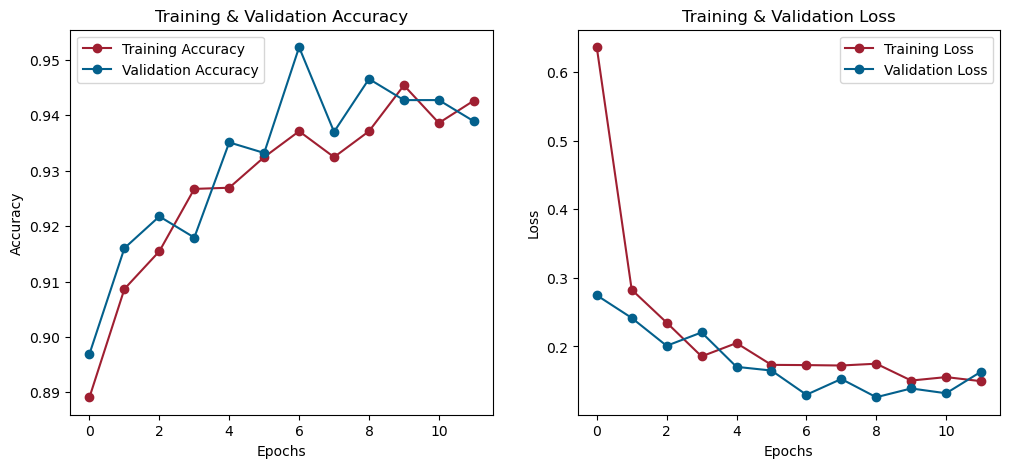

In [77]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2, figsize = (12, 5))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs , train_acc , 'o-' , label = 'Training Accuracy',color = '#9f1f31')
ax[0].plot(epochs , val_acc , 'o-' , label = 'Validation Accuracy', color = '#03608C')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].grid(False)

ax[1].plot(epochs , train_loss , 'o-' , label = 'Training Loss', color = '#9f1f31')
ax[1].plot(epochs , val_loss , 'o-' , label = 'Validation Loss', color = '#03608C')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].grid(False)

plt.show()

20/20 [==============================] - 0s 7ms/step


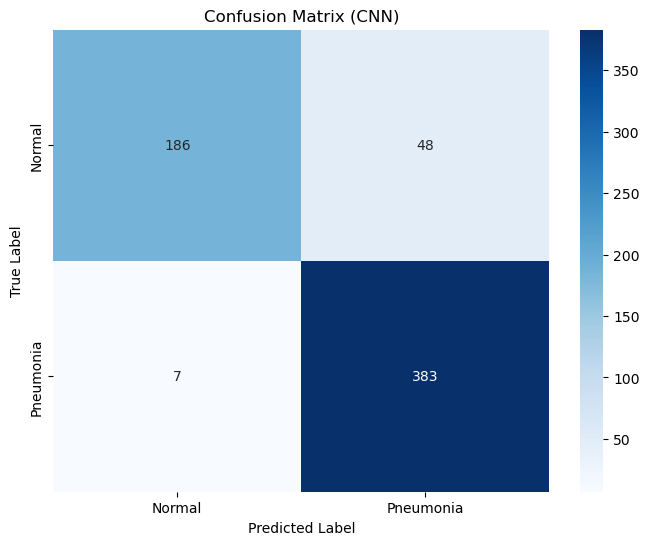

In [96]:
predictions = model.predict(x_test2)
predicted_labels = np.round(predictions).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (CNN)")
plt.show()


## Model Prediction

In [94]:
def display_images_in_layout(images, original_labels, predicted_labels, class_names, num_columns=5, num_imgs=20):
    # Calculate the number of rows based on num_columns
    num_rows = int(num_imgs / num_columns)

    # Randomly generate index of shown images
    random_idx = np.random.choice(len(images), num_imgs, replace=False)

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

    # Loop through images and labels to display
    for i in range(len(random_idx)):
        row, col = divmod(i, num_columns)
        # Display image
        ax = axs[row, col]
        ax.imshow(images[random_idx[i]], cmap='gray')
        
        # Map numeric labels to class names
        original_label = class_names[int(original_labels[random_idx[i]])]
        predicted_label = class_names[int(predicted_labels[random_idx[i]])]
        title_color = 'green' if original_label == predicted_label else 'red'
        
        
        ax.set_title(f"Original: {original_label}\nPredicted: {predicted_label}", color = title_color)
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.savefig('Prediction of Pneumonia')
    plt.show()

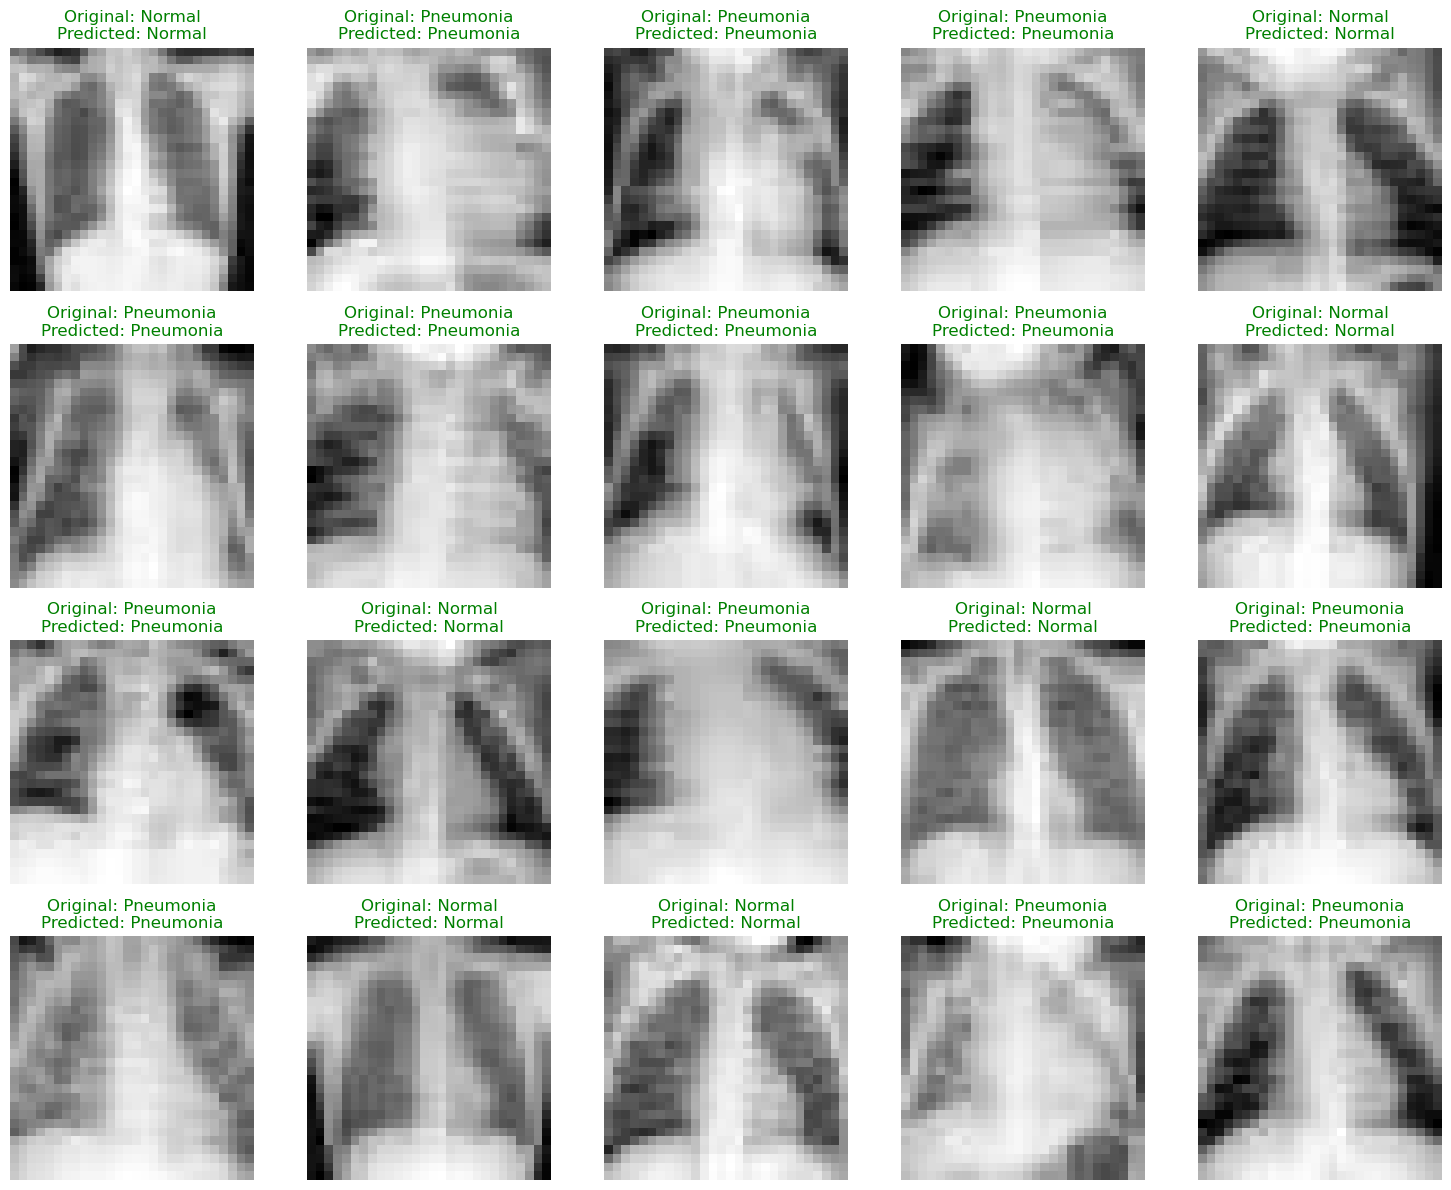

In [95]:
class_names = ["Normal","Pneumonia"]

display_images_in_layout(x_test2, y_test, predicted_labels, class_names, num_columns=5, num_imgs=20)